Found 3065 .mat files to process
⚠️ Error reading /kaggle/input/figshare-datset/cvind.mat: "Unable to synchronously open object (object 'cjdata' doesn't exist)"
✅ Conversion complete. Images are stored in: /kaggle/working/brain_tumor_images_vgg16
✅ Found 3064 images across 3 classes
🧾 Class distribution:
 class
glioma        1426
pituitary      930
meningioma     708
Name: count, dtype: int64
📊 Train: 2083, Val: 368, Test: 613
Found 2083 validated image filenames belonging to 3 classes.
Found 368 validated image filenames belonging to 3 classes.
Found 613 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 45s 524ms/step - accuracy: 0.4709 - loss: 1.2710 - val_accuracy: 0.6712 - val_loss: 0.9006
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 500ms/step - accuracy: 0.5692 - loss: 0.8862 - val_accuracy: 0.6087 - val_loss: 0.8269
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 525ms/step - accuracy: 0.6092 - loss: 0.8399 - val_accuracy: 0.7174 - val_loss: 0.6817
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 34s 510ms/step - accuracy: 0.6666 - loss: 0.7367 - val_accuracy: 0.6875 - val_loss: 0.7351
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 520ms/step - accuracy: 0.6811 - loss: 0.7070 - val_accuracy: 0.8179 - val_loss: 0.4018
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 488ms/step - accuracy: 0.7899 - loss: 0.4765 - val_accuracy: 0.8071 - val_loss: 0.4125
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 490ms/step - accuracy: 0.8142 - loss: 0.4266 - val_accuracy: 0.8315 - val_loss: 0.3565
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 466ms/step - accuracy: 0.7014 - loss: 0.7217 - val_accu

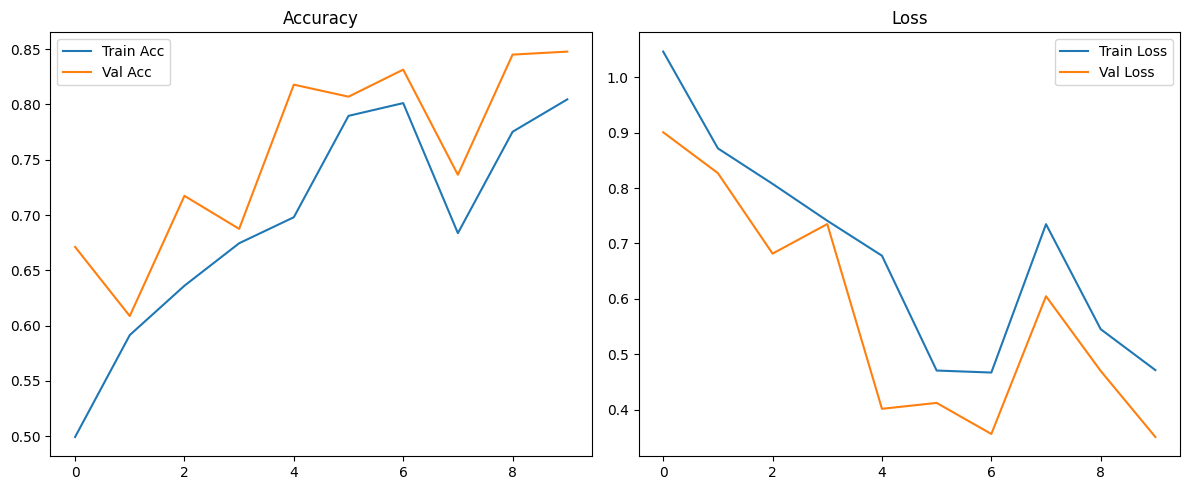

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.8510 - loss: 0.3472
✅ Test Accuracy: 0.8532
📉 Test Loss: 0.3359
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step

Classification Report:
               precision    recall  f1-score   support

      glioma       0.96      0.83      0.89       285
  meningioma       0.68      0.77      0.73       142
   pituitary       0.85      0.95      0.90       186

    accuracy                           0.85       613
   macro avg       0.83      0.85      0.84       613
weighted avg       0.87      0.85      0.86       613



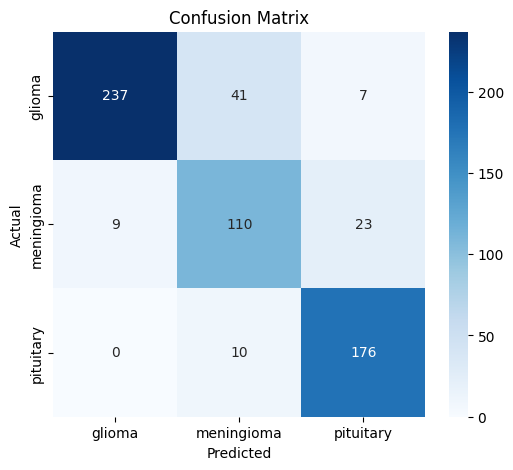

In [35]:
import os
import glob
import h5py
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# ======================
# ⚙️ Parameters
# ======================
DATASET_PATH = "/kaggle/input/figshare-datset"
IMAGE_PATH = "/kaggle/working/brain_tumor_images_vgg16"
IMG_SIZE = (224, 224)   # VGG16 expects 224x224
BATCH_SIZE = 32
EPOCHS = 10

os.makedirs(IMAGE_PATH, exist_ok=True)

# ======================
# 🗂 Step 0: Convert .mat → .png
# ======================
mat_files = glob.glob(os.path.join(DATASET_PATH, "**", "*.mat"), recursive=True)
print(f"Found {len(mat_files)} .mat files to process")

for f in mat_files:
    try:
        with h5py.File(f, "r") as mat:
            cjdata = mat["cjdata"]

            image = np.array(cjdata["image"]).T
            label = int(np.array(cjdata["label"])[0][0])  # 1=meningioma, 2=glioma, 3=pituitary

            if label == 1:
                cls = "meningioma"
            elif label == 2:
                cls = "glioma"
            elif label == 3:
                cls = "pituitary"
            else:
                cls = "unknown"

            out_dir = os.path.join(IMAGE_PATH, cls)
            os.makedirs(out_dir, exist_ok=True)

            img_norm = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")
            out_name = os.path.join(out_dir, os.path.basename(f).replace(".mat", ".png"))
            cv2.imwrite(out_name, img_norm)

    except Exception as e:
        print(f"⚠️ Error reading {f}: {e}")

print("✅ Conversion complete. Images are stored in:", IMAGE_PATH)

# ======================
# 🧠 Step 1: Collect all images
# ======================
image_paths = glob.glob(os.path.join(IMAGE_PATH, "**", "*.png"), recursive=True)
if len(image_paths) == 0:
    raise ValueError("❌ No images found after conversion!")

labels = [os.path.basename(os.path.dirname(p)) for p in image_paths]
df = pd.DataFrame({'filename': image_paths, 'class': labels})

NUM_CLASSES = df['class'].nunique()
print(f"✅ Found {len(df)} images across {NUM_CLASSES} classes")
print("🧾 Class distribution:\n", df['class'].value_counts())

# ======================
# 🧪 Step 2: Split dataset
# ======================
train_df, test_df = train_test_split(df, stratify=df['class'], test_size=0.20, random_state=42)
train_df, val_df = train_test_split(train_df, stratify=train_df['class'], test_size=0.15, random_state=42)
print(f"📊 Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# ======================
# 🔄 Step 3: Data generators
# ======================
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(train_df, x_col='filename', y_col='class',
                                              target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                              class_mode='categorical')
val_gen = valid_datagen.flow_from_dataframe(val_df, x_col='filename', y_col='class',
                                            target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                            class_mode='categorical')
test_gen = test_datagen.flow_from_dataframe(test_df, x_col='filename', y_col='class',
                                            target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                            class_mode='categorical', shuffle=False)

# ======================
# 🔧 Step 4: Build VGG16 model
# ======================
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
preds = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=preds)

# ======================
# ⚙️ Step 5: Compile
# ======================
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ======================
# 📦 Step 6: Callbacks
# ======================
checkpoint = ModelCheckpoint('vgg16_best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# ======================
# 🏋️ Step 7: Train
# ======================
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=EPOCHS,
                    callbacks=[checkpoint])

# ======================
# 📈 Step 8: Plot history
# ======================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# ======================
# 🧪 Step 9: Evaluate on test set
# ======================
loss, acc = model.evaluate(test_gen)
print(f"✅ Test Accuracy: {acc:.4f}")
print(f"📉 Test Loss: {loss:.4f}")

# ======================
# 🧾 Step 10: Classification report & confusion matrix
# ======================
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)
class_labels = list(test_gen.class_indices.keys())

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
